In [1]:
from typing import List, Tuple
from helper.helper_functions import load_dataset, save_model, get_features_and_target, encode_all_features
from helper.clfmodel_functions import tune_model, seq_feat_selection, multi_metric_cv, plot_multi_score_cv_results, forward_feat_selection_hypertuning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector

### Loading the cleaned dataset

In [2]:
data = load_dataset('../data/assignment2_income_cleaned.xlsx')

### Feature Engineering (encoding) & Train-Test Split

In [3]:
# Splitting the data into features (X) and target (y)
X, y = get_features_and_target(data, 'income')
columns_to_exclude = ['age', 'ability to speak english', 'gave birth this year']
# Encoding the features and target, and excluding some columns
X_encoded, y_encoded = encode_all_features(X, y, columns_to_exclude)
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [4]:
X_train

,education,workinghours,sex_Female,sex_Male,occupation_Construction/Extraction,occupation_Counseling/Mental Health Services,occupation_Education,occupation_Entertainment,"occupation_Farming, Fishing, Forestry",occupation_Finance/Accounting,...,marital status_Divorced,marital status_Husband,marital status_Never married,marital status_Separated,marital status_Widowed,marital status_Wife,workclass_governmental,workclass_no paid work,workclass_private,workclass_self employed
6317,16,36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
740,22,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3781,16,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7850,18,65,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2963,19,44,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,19,25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5191,16,28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5390,16,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
860,20,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Model

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [5]:
# K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_model.fit(X_train, y_train)
# Predictions
knn_preds = knn_model.predict(X_test)
# Accuracy evaluation
knn_accuracy = accuracy_score(y_test, knn_preds)

print(classification_report(y_test, knn_preds))
print("K-Nearest Neighbors Accuracy:", knn_accuracy)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1175
           1       0.66      0.65      0.65       625

    accuracy                           0.76      1800
   macro avg       0.74      0.73      0.73      1800
weighted avg       0.76      0.76      0.76      1800

K-Nearest Neighbors Accuracy: 0.76


In [6]:
seq_feat_sel = False
if seq_feat_sel:
    seq_feat_selection(KNeighborsClassifier(), X_train, y_train)

### Hyperparameter tuning

In [7]:
tune = True
if tune:
    param_grid = {
                'n_neighbors': np.arange(2, 31, 1),
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
    }
    
    best_params, best_model, best_accuracy = tune_model(KNeighborsClassifier(), X_train, y_train, X_test, y_test, param_grid, top_n=10)
    
    print("Best Hyperparameters:", best_params)
    print("Best Model:", best_model)
    print("Best Model Accuracy:", best_accuracy)

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best Hyperparameters: {'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
Best Model: KNeighborsClassifier(n_neighbors=29, p=1)
Best Model Accuracy: 0.7761111111111111


https://www.geeksforgeeks.org/feature-selection-techniques-in-machine-learning/


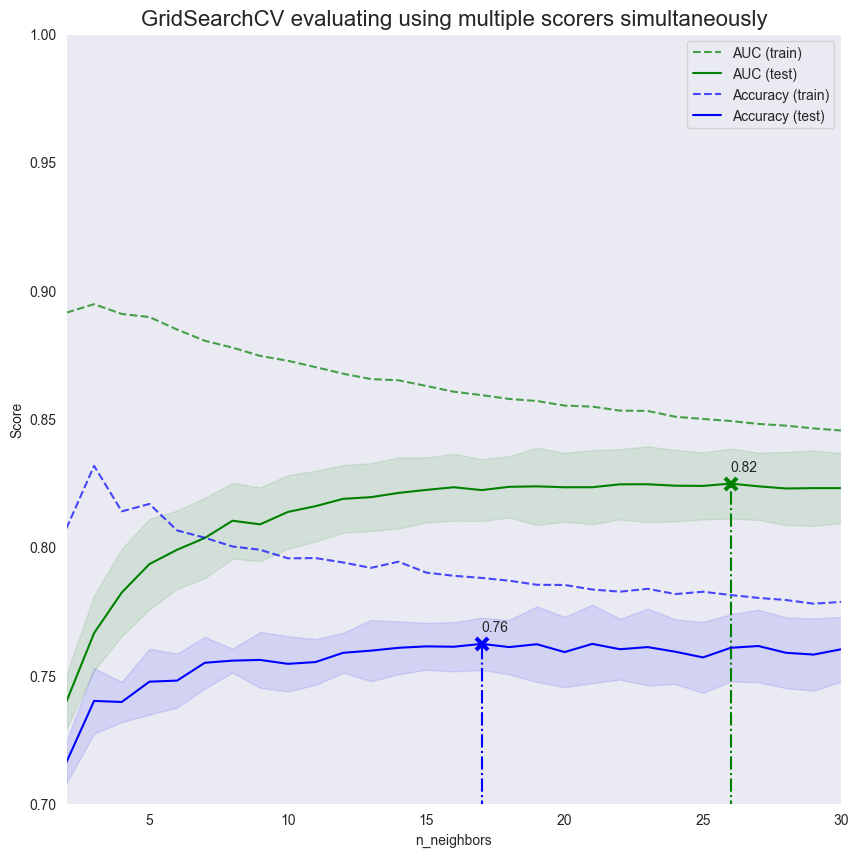

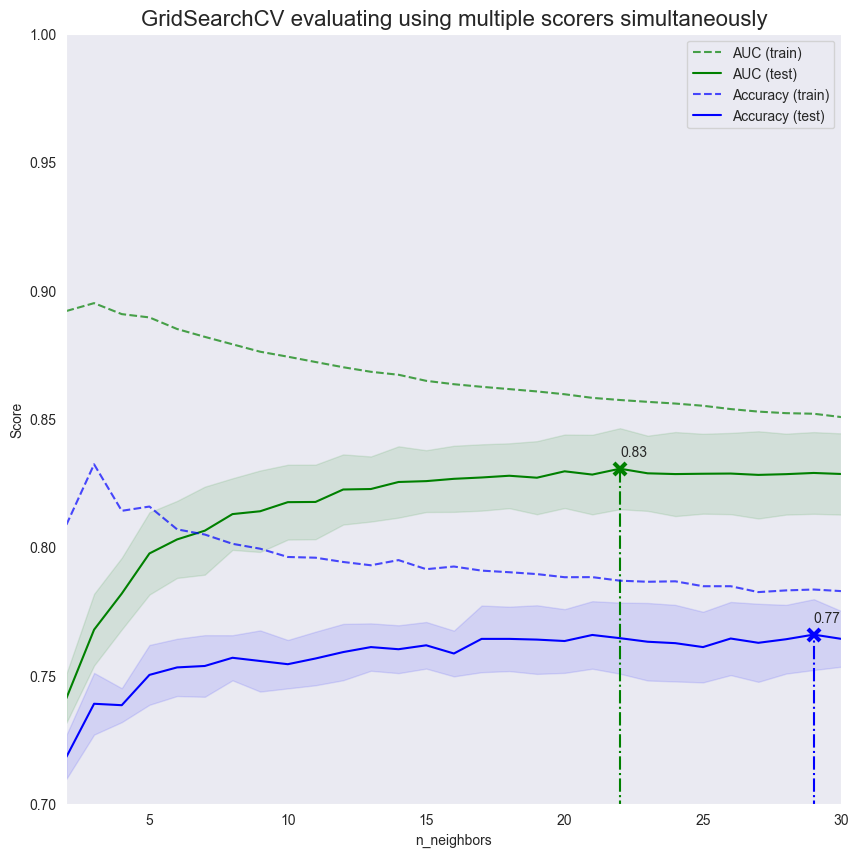

In [10]:
is_multi_metric_cv = True
if is_multi_metric_cv:
    # Define the scorers
    scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
    
    n_neighbours_param_min = 2
    n_neighbours_param_max = 31
    param_grid = {"n_neighbors": range(n_neighbours_param_min, n_neighbours_param_max, 1)}

    results = multi_metric_cv(KNeighborsClassifier(p=2), scoring, X_train, y_train, param_grid)
    plot_multi_score_cv_results("n_neighbors", n_neighbours_param_min, n_neighbours_param_max, 0.7, 1, results, "param_n_neighbors", int, scoring)
    
    results = multi_metric_cv(KNeighborsClassifier(p=1), scoring, X_train, y_train, param_grid)
    plot_multi_score_cv_results("n_neighbors", n_neighbours_param_min, n_neighbours_param_max, 0.7, 1, results, "param_n_neighbors", int, scoring)

In [9]:
# Forward feature selection with hyperparameter tuning
if True:
    best_subset, best_params, best_score = forward_feat_selection_hypertuning(X_train, y_train, X_test, y_test)
    
    print("Best subset of features:", best_subset)
    print("Best hyperparameters:", best_params)
    print("Best model accuracy:", best_score)
    
    # Use the best subset and best hyperparameters for final model
    final_model = KNeighborsClassifier(**best_params)
    final_model.fit(X_train[best_subset], y_train)
    final_model_preds = final_model.predict(X_test[best_subset])
    final_model_accuracy = accuracy_score(y_test, final_model_preds)
    
    print(classification_report(y_test, final_model_preds))

KeyError: "None of [Index(['age'], dtype='object')] are in the [columns]"

Feature Selection: Ensure that sensitive attributes such as sex are not included as features in the model. This helps prevent the model from directly learning discriminatory patterns based on sensitive attributes.

Fair Representation: Balance the representation of different groups within the dataset. Ensure that the dataset is representative of the population with respect to sex and other sensitive attributes. This can help mitigate bias in the model's predictions.

Fair Preprocessing: Apply preprocessing techniques that aim to mitigate bias in the dataset. For example, use techniques such as reweighting or resampling to balance the dataset with respect to sensitive attributes.

Reweighing:
Adjust the weights of instances in your dataset to balance the impact of different groups.
Assign higher weights to underrepresented groups (e.g., females) and lower weights to overrepresented groups (e.g., males).
This helps reduce bias during model training.
Suppression:
Remove or suppress the sensitive attribute (‘sex’) from the dataset.
Train your model without using this attribute.
Note that this approach may lead to information loss, so use it cautiously.
Massaging the Dataset:
Modify class labels to achieve fairness.
For instance, you can swap the labels for different groups (e.g., relabel some ‘male’ instances as ‘female’ and vice versa).
This ensures that the model does not learn discriminatory patterns based on the sensitive attribute.
Resampling Techniques:
Oversample the underrepresented group (e.g., females) or undersample the overrepresented group (e.g., males).
This balances the class distribution and reduces bias.


Model Evaluation: Evaluate the model's performance and fairness across different subgroups defined by sensitive attributes such as sex. Use metrics such as disparate impact ratio, equal opportunity difference, or predictive parity to assess fairness.

In [ ]:
from sklearn.metrics import confusion_matrix

X_test['sex'] = X_test['sex_Male'] * 1
X_train['sex'] = X_train['sex_Male'] * 1
X_test = X_test.drop(columns=['sex_Male', 'sex_Female'])
X_train = X_train.drop(columns=['sex_Male', 'sex_Female'])

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

# calculate DI:
# DI = (num_positives(priviliged=False) / num_instances(priviliged=False)) / (num_positives(priviliged=True) / num_instances(priviliged=True))
num_instances_priv_false = X_test[X_test['sex']==0].shape[0]
num_instances_priv_true = X_test[X_test['sex']==1].shape[0]

num_positives_priv_false = np.sum((y_pred == 1) & (X_test['sex'] == 0))
num_positives_priv_true = np.sum((y_pred == 1) & (X_test['sex'] == 1))

DI = (num_positives_priv_false / num_instances_priv_false) / (num_positives_priv_true / num_instances_priv_true)

print(f"Disparate Impact (DI): {DI:.2f}")

# # Get predicted labels for females and males
# y_pred_female = y_pred[X_test['sex'] == 0]
# y_pred_male = y_pred[X_test['sex'] == 1]
# 
# # Calculate the probability of predicted positive outcomes for females and males
# prob_positive_female = np.mean(y_pred_female)
# prob_positive_male = np.mean(y_pred_male)
# 
# # Calculate the Disparate Impact (DI) criterion
# DI = prob_positive_female / prob_positive_male
# 
# print(f"Disparate Impact (DI): {DI:.2f}")

# # Make predictions on the test set
# y_pred = knn_model.predict(X_test)
# 
# # Create a confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# 
# # Extract counts for each group (male and female)
# male_count = np.sum(X_test['sex_Male'])
# female_count = np.sum(X_test['sex_Female'])
# 
# # Calculate favorable outcomes (e.g., 'income' = 1) for each group
# male_favorable = conf_matrix[1, 1]
# female_favorable = conf_matrix[0, 1]
# 
# # Calculate disparate impact
# disparate_impact = (female_favorable / female_count) / (male_favorable / male_count)
# 
# # Print the result
# print(f"Disparate Impact: {disparate_impact:.2f}")

# Interpretation:
# - If disparate impact = 1, outcomes are equally favorable for both groups.
# - If disparate impact > 1, one group has more favorable outcomes than the other.
# - If disparate impact < 1, the opposite is true.

# You can set a threshold (e.g., 0.8) to determine fairness based on your context.

In [ ]:
# conf_matrix # Thus in binary classification, the count of true negatives is C0,0, false negatives is C1,0, true positives is C1,1 and false positives is C0,1

In [ ]:
# Disparate Impact Ratio
from aif360.sklearn.metrics import disparate_impact_ratio
disparate_impact = disparate_impact_ratio(y_true=y_test, y_pred=y_pred, prot_attr=X_test['sex'])
print("Disparate Impact Ratio:", disparate_impact)


In [ ]:
# from aif360.sklearn.metrics import statistical_parity_difference
# 
# # encode the 'sex' feature
# X['sex'] = X['sex'].map({'Male': 0, 'Female': 1})
# y = y.map({'low': 0, 'high': 1})
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# # Train your KNN model
# knn_model = KNeighborsClassifier()
# knn_model.fit(X_train, y_train)
# 
# # Predictions
# knn_preds = knn_model.predict(X_test)
# 
# # Calculate fairness metrics using model predictions and specify 'sex' as the sensitive attribute
# spd_sex = statistical_parity_difference(y_true=y_test, y_pred=knn_preds, sensitive_features=X_test['sex'])
# eo = equal_opportunity_difference(y_true=y_test, y_pred=knn_preds, sensitive_features=X_test['sex'])
# aod = average_odds_difference(y_true=y_test, y_pred=knn_preds, sensitive_features=X_test['sex'])
# apv = average_predictive_value_difference(y_true=y_test, y_pred=knn_preds, sensitive_features=X_test['sex'])
# 
# print("Statistical Parity Difference:", spd_sex)
# print("Equal Opportunity Difference:", eo)
# print("Average Odds Difference:", aod)
# print("Average Predictive Value Difference:", apv)

In [ ]:
# Saving the model
save_model(final_model, '../output/saved_models/knn_model.joblib')